In [252]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [254]:
df = pd.read_csv('data/train_Titan.csv')

In [255]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [256]:
df.shape

(891, 12)

**Drop columns that has little impact based on common snse**

In [257]:
df.drop(['Name', 'Cabin', 'Ticket', 'PassengerId'],axis=1, inplace=True)

**Drop all rows with NaN**

In [258]:
df_new = df.dropna(how='any')

In [259]:
df_new.shape

(712, 8)

**Convert string values in categorical column to binary values**

In [260]:
df_new['Sex'] = df_new['Sex'].map({'male':1, 'female':0})

/Users/ziru/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


**Convert string values in categorical column to binary values using** `pd.get_dummies()`

In [261]:
df_new = pd.concat([df_new, pd.get_dummies(df_new['Embarked'])], axis=1)

In [262]:
df_new.drop('Embarked', axis=1, inplace=True)

In [263]:
df_new.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,1,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,0,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,0,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,0,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0


In [303]:
X = df_new[df_new.drop('Survived', axis =1).columns]
y = df_new['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y)

**Use Random Forest model to get feature importance**

In [219]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
feature_names = X_train.columns
y_pred = clf.predict(X_test)

importances = clf.feature_importances_
important_names = feature_names[importances > np.mean(importances)]
print important_names

#[(feature_name, feature_imp) for feature_name, feature_imp in zip(feature_names,importances)]

Index([u'Sex', u'Age', u'Fare'], dtype='object')


In [220]:
# Tried to use only the top3 features, but result is not improving
X = df_new[df_new.drop('Survived', axis =1).columns]
y = df_new['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y)

**Use** `GridSearchCV` **to pick the best hyperparameters for classification models
Because this is a classification problem, I chose roc_auc to be the scoring standard**

In [221]:
# Random Forest
random_forest_grid = {'max_depth': [5, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100],
                      'random_state': [1]}
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='accuracy')
rf_gridsearch.fit(X_train, y_train)

print "best parameters:", rf_gridsearch.best_params_

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   30.1s finished


best parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 100, 'min_samples_split': 2, 'random_state': 1, 'max_features': None, 'max_depth': 5}


**Check the CV accurary of the best random forest model**

In [222]:
cross_val_score(best_rf_model, X, y, cv = 5, scoring = 'accuracy').mean()

0.7936044476949482

In [223]:
# Gradient Boost
gradient_boosting_grid = {'learning_rate': [0.05, 0.02],
                          'loss': ['deviance', 'exponential'],
                          'max_depth': [4],
                          'min_samples_leaf': [1, 2, 4],
                          'max_features': [1.0, 0.5, 0.1],
                          'subsample': [1.0, 0.5],
                          'n_estimators': [100],
                          'random_state': [1]}
gbclf_gridsearch = GridSearchCV(GradientBoostingClassifier(), 
                              gradient_boosting_grid,
                              n_jobs=-1,
                              scoring='accuracy')
gbclf_gridsearch.fit(X_train, y_train)
print "best parameters:", gbclf_gridsearch.best_params_

best_gbclf_model = gbclf_gridsearch.best_estimator_

best parameters: {'loss': 'deviance', 'learning_rate': 0.02, 'min_samples_leaf': 1, 'n_estimators': 100, 'subsample': 1.0, 'random_state': 1, 'max_features': 0.5, 'max_depth': 4}


**Check the CV accurary of the best Gradient Boosting model**

In [224]:
cross_val_score(best_gbclf_model, X, y, cv = 5, scoring = 'accuracy').mean()

0.8119150053821913

In [ ]:
from sklearn.linear_model import LogisticRegression

In [275]:
# AdaBoost
ada_boosting_grid = {'learning_rate': [0.05, 0.02, 0.01],
                          'n_estimators': [200, 300],
                          'random_state': [1]}
adab_gridsearch = GridSearchCV(AdaBoostClassifier(), 
                              ada_boosting_grid,
                              n_jobs=-1,
                              scoring='accuracy')
adab_gridsearch.fit(X_train, y_train)
print "best parameters:", adab_gridsearch.best_params_

best_adab_model = adab_gridsearch.best_estimator_

best parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'random_state': 1}


**Check the CV accurary of the best Ada Boosting model**

In [276]:
cross_val_score(best_adab_model, X, y, cv = 5, scoring = 'accuracy').mean()

0.78239607760135177

In [227]:
def stage_score_plot(gdbr00, X_train, y_train, X_test, y_test):
    gdbr00.fit(X_train, y_train)
    est00_train = gdbr00.staged_predict(X_train)
    est00_test = gdbr00.staged_predict(X_test)
    mse00_train = []
    mse00_test = []
    for e00 in est00_train:
        mse00_train.append(sklearn.metrics.accuracy_score(y_train, e00))
    for e00 in est00_test:
        mse00_test.append(sklearn.metrics.accuracy_score(y_test, e00))
    
    plt.plot(np.arange(1,101,1), mse00_train, label='train')
    plt.plot(np.arange(1,101,1), mse00_test, label='test')
    plt.legend()

**Get a sense of train and test score for each iteration of GBC**

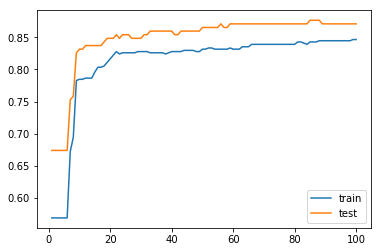

In [228]:
stage_score_plot(best_gbclf_model, X_train, y_train, X_test, y_test)

**Use a voting classifier to vote among 3 classifiers**

In [301]:
votingC = VotingClassifier(estimators=[('rfc', best_rf_model),
                                       ('adac',best_adab_model),('gbc',best_gbclf_model)], voting='hard')

#votingC = votingC.fit(X_train, y_train)

In [304]:
cross_val_score(votingC, X, y, cv = 5, scoring = 'accuracy').mean()

0.80069664627650838

## For Kaggle submission

In [283]:
test_df = pd.read_csv('data/test_Titan.csv')

In [284]:
def check_nan(df, cols):
    for c in cols:
        print c , ' has ' , sum(df[c].isnull()) , 'null/NAN values'
    return True

**Check for NaN**

In [285]:
check_nan(test_df, test_df.columns)

PassengerId  has  0 null/NAN values
Pclass  has  0 null/NAN values
Name  has  0 null/NAN values
Sex  has  0 null/NAN values
Age  has  86 null/NAN values
SibSp  has  0 null/NAN values
Parch  has  0 null/NAN values
Ticket  has  0 null/NAN values
Fare  has  1 null/NAN values
Cabin  has  327 null/NAN values
Embarked  has  0 null/NAN values


True

In [286]:
test_df.drop(['Name','Cabin','Ticket', 'PassengerId'],axis=1, inplace=True)

**Fill NaN in Age and Fare column:**

**1. Check the distribution of ages**

**2. Based on the skewness, decide if use mean or median to fill NaN**

(array([ 16.,  16.,  71.,  97.,  43.,  37.,  25.,  17.,   9.,   1.]),
 array([  0.17 ,   7.753,  15.336,  22.919,  30.502,  38.085,  45.668,
         53.251,  60.834,  68.417,  76.   ]),
 <a list of 10 Patch objects>)

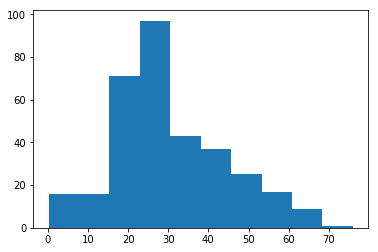

In [287]:
fig, ax = plt.subplots()
ax.hist(test_df[test_df['Age'].notnull()]['Age'], bins=10)

** Because the Age distribution is skewed to the right, median should be the best representative of the central location of the data**

In [288]:
age_median = test_df[test_df['Age'].notnull()]['Age'].median()

In [289]:
test_df['Age']=test_df['Age'].fillna(age_median)

(array([ 338.,   48.,   11.,    2.,   10.,    7.,    0.,    0.,    0.,    1.]),
 array([   0.     ,   51.23292,  102.46584,  153.69876,  204.93168,
         256.1646 ,  307.39752,  358.63044,  409.86336,  461.09628,
         512.3292 ]),
 <a list of 10 Patch objects>)

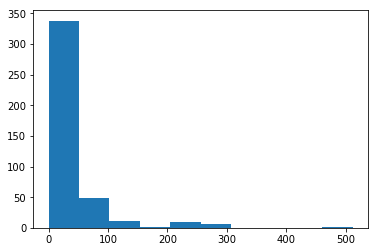

In [290]:
fig, ax = plt.subplots()
ax.hist(test_df[test_df['Fare'].notnull()]['Fare'], bins=10)

** Because the Fare distribution is skewed to the right, median should be the best representative of the central location of the data**

In [291]:
age_median = test_df[test_df['Fare'].notnull()]['Fare'].median()
test_df['Fare']=test_df['Fare'].fillna(age_median)

In [292]:
check_nan(test_df, test_df.columns)

Pclass  has  0 null/NAN values
Sex  has  0 null/NAN values
Age  has  0 null/NAN values
SibSp  has  0 null/NAN values
Parch  has  0 null/NAN values
Fare  has  0 null/NAN values
Embarked  has  0 null/NAN values


True

In [293]:
test_df['Sex'] = test_df['Sex'].map({'male':1, 'female':0})

In [294]:
test_df_new = pd.concat([test_df, pd.get_dummies(test_df['Embarked'])], axis=1)

In [295]:
test_df_new.drop('Embarked', axis=1, inplace=True)

In [296]:
test_df_new.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,3,1,34.5,0,0,7.8292,0.0,1.0,0.0
1,3,0,47.0,1,0,7.0000,0.0,0.0,1.0
2,2,1,62.0,0,0,9.6875,0.0,1.0,0.0
3,3,1,27.0,0,0,8.6625,0.0,0.0,1.0
4,3,0,22.0,1,1,12.2875,0.0,0.0,1.0


In [297]:
X = test_df_new

In [298]:
X_train = df_new[df_new.drop('Survived', axis =1).columns]
y_train = df_new['Survived']
votingC.fit(X_train, y_train)
predictions = votingC.predict(X)

In [299]:
sub_df = pd.read_csv('data/test_Titan.csv')

In [300]:
submission = pd.DataFrame({ 'PassengerId': sub_df['PassengerId'],
                            'Survived': predictions })
submission.to_csv("submission_titanic.csv", index=False)

### Kaggle ranked 1684 out of 9354

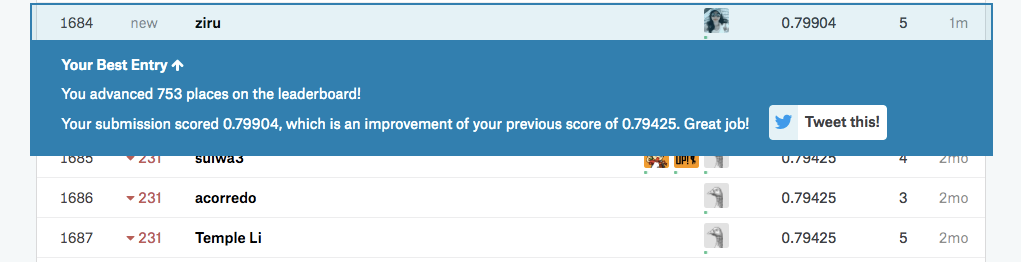